# Project Introduction 

This project presents a hypothetical problem where I must identify potential major donors to a charity. Studies have found that donors making more than 50,000 USD annually have the potential to be major donors. Your task is to use machine learning algorithms to help identify individuals with an annual income of 50,000 USD or more.

This notebook will contain the initial data analysis as well as the machine learning algorithm development process. The optimal algorithm will than be used in a web app so that customers may input their parameters in order to return a prediction as to whether an individual is likely to be a potential donor or not. 

### Table of Contents:
- [Loading in the Data](#Load)
- [Data Exploration (EDA)](#Explore)
- [Data Cleaning/Preprocessing](#Clean)
- [Model Testing and Validation](#Test)
- [Model Pipeline Development (ETL)](#Pipe)



<a id="Load"></a>
### Loading in the Data

This section includes the basic loading phase of our training and testing data. 

In [181]:
# Importing basic libraries for data analytics 
import numpy as np
import pandas as pd

# Libraries for visualisations
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import norm
import scipy 
import matplotlib.mlab as mlab
%matplotlib inline

# Import supplementary visualization code visuals.py
import visuals as vs

# Used for tracking model training and testing time
from time import time

# Importing 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# Import sklearn.preprocessing.StandardScaler for feature scaling
from sklearn.preprocessing import MinMaxScaler
# Import train_test_split
from sklearn.model_selection import train_test_split
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score
# Importing Precision function
from sklearn.metrics import precision_score


# Importing the three supervised learning models from sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Confusion matrix
from sklearn.metrics import confusion_matrix

# Importing pickle to help with model saving and loading
import pickle

In [422]:
# List of column names to pass to the read_csv function
col_names = ['age','workclass','fnlwgt','education','education_years','marital_status','occupation','relationship','race',
         'sex','capital_gain','capital_loss','hours_worked_per_week','native_country','income']

In [423]:
# Loading in our training data
data = pd.read_csv('adultdata', names=col_names)

In [4]:
# Checking the size of our data set
data.shape

(32561, 15)

In [5]:
# A quick visual check
data.head()

,age,workclass,fnlwgt,education,education_years,marital_status,occupation,realtionship,race,sex,capital_gain,capital_loss,hours_worked_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [424]:
# Loading in the testing data 
data_test = pd.read_csv('adulttest', names=col_names, skiprows=1)

In [425]:
# Quick visual check 
data_test.head()

,age,workclass,fnlwgt,education,education_years,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_worked_per_week,native_country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [8]:
# Number of rows should be about 1/3rd
data_test.shape

(16281, 15)

In [9]:
# Checking our number of rows and columns are correct
assert round(data.shape[0]/data_test.shape[0]) == 2
assert data.shape[1] == data_test.shape[1]
print('Seems like we loaded in our data correctly!')

Seems like we loaded in our data correctly!


<a id="Explore"></a>
### Data Exploration

Some of the key things we will want to analyze in our data will be:
- Distribution of Continuous and Categorical Features
- Missing Values 
- Checking for Colinearity in our predictors

In [10]:
# Checking for missing data
data.isna().sum()

age                      0
workclass                0
fnlwgt                   0
education                0
education_years          0
marital_status           0
occupation               0
realtionship             0
race                     0
sex                      0
capital_gain             0
capital_loss             0
hours_worked_per_week    0
native_country           0
income                   0
dtype: int64

- An unusual but very welcomed sight. No missing values or corrupt data!

In [11]:
# Checking our data types
data.dtypes

age                       int64
workclass                object
fnlwgt                    int64
education                object
education_years           int64
marital_status           object
occupation               object
realtionship             object
race                     object
sex                      object
capital_gain              int64
capital_loss              int64
hours_worked_per_week     int64
native_country           object
income                   object
dtype: object

In [12]:
def plot_bar(data, label):
    '''
    INPUT:
    data - (object) Continuous array of categorical data 
    label - (str) Label for y-axis and title
    
    OUTPUT:
    plt - Bar chart of the feature and its values

    Description:
    Returns a bar chart of the data and passes a visualisation as well as the mean and standard deviation. 
    '''
    plt.bar(list(data.value_counts().index), list(data.value_counts()), facecolor = 'orange', alpha=0.75)
    #n, bins, patches = plt.hist(data, 20, density=1, facecolor='green', alpha=0.75)
    #y = scipy.stats.norm.pdf( bins, mu, sigma)
    
    
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.title('Bar chart of {}:'.format(label))
    plt.ylabel('Count');

    return plt

In [13]:
# List of categorical features
cat_feats = list(data.dtypes[data.dtypes == 'object'].index)

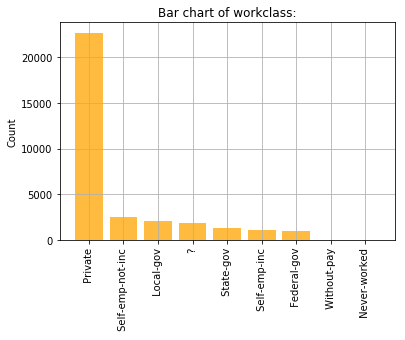

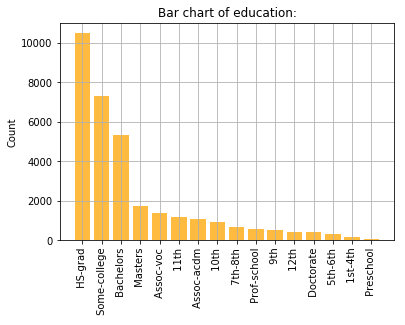

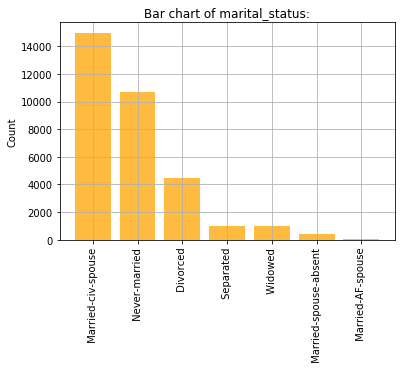

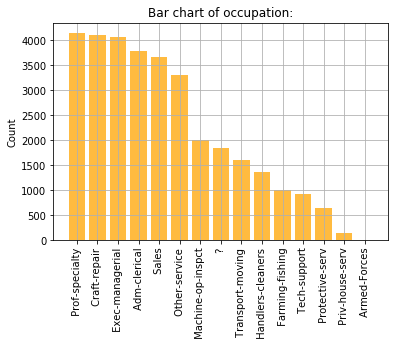

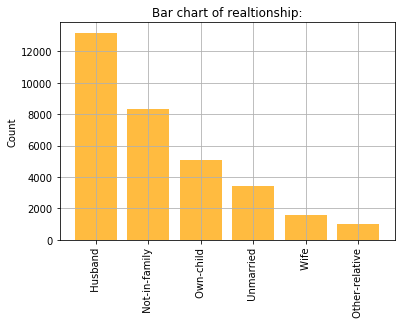

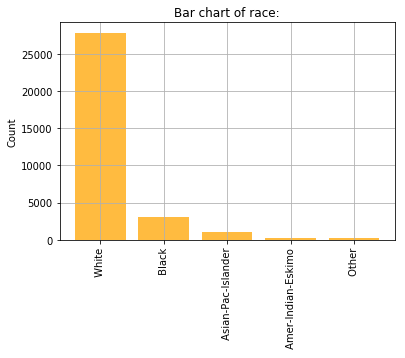

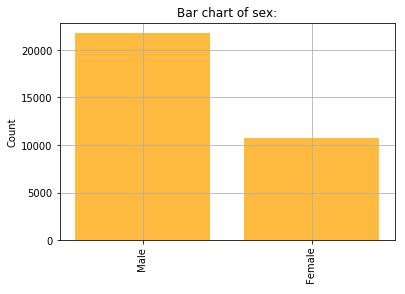

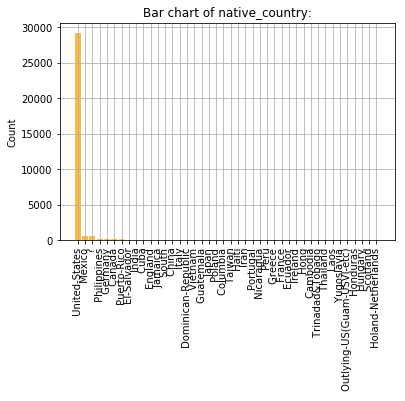

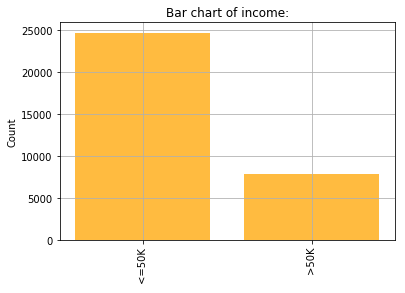

In [14]:
for cat in cat_feats:
    plt.subplot(1,1,1)
    plot_bar(data[cat], cat)
    plt.show()

So it seems we do infact have some missing data. It would be best to understand the magnitude of the issue by understanding the percentage of the data set that has missing data and how many total data points exist with a ' ?' placeholder in order to understand how to best deal with the missing data points (imputation / removal). 
- ? in workclass
- ? in occupation
- ? in native country


In [15]:
# Having a look at our missing data in each column
print(data.workclass.value_counts()[data.workclass.value_counts().index == ' ?'])
print(data.occupation.value_counts()[data.occupation.value_counts().index == ' ?'])
print(data.native_country.value_counts()[data.native_country.value_counts().index == ' ?'])

 ?    1836
Name: workclass, dtype: int64
 ?    1843
Name: occupation, dtype: int64
 ?    583
Name: native_country, dtype: int64


In [16]:
# Number of ' ?'/ missing data points in our data frame
data.isin([' ?']).sum(axis=0).sum()

4262

In [17]:
# Number of rows with missing data 
num_rows = (data.isin([' ?']).sum(axis=1) > 0).sum()
print('Our dataset contains {} missing rows which is a {:.2f}% of our dataset'.format(num_rows, 100*num_rows/data.shape[0]))

Our dataset contains 2399 missing rows which is a 7.37% of our dataset


In [18]:
# Number of rows with '?''s in our testing data set
num_rows_test = (data_test.isin([' ?']).sum(axis=1) > 0).sum()
print('Our dataset contains {} missing rows which is a {:.2f}% of our test dataset'.format(num_rows_test, 100*num_rows_test/data.shape[0]))


Our dataset contains 1221 missing rows which is a 3.75% of our test dataset


For the sake of model performace I will **remove the unknown values** as we are looking to predict individuals incomes based on concrete inputes. 

While it may be useful to have a model that can handle unknowns and predict whether or not an individual has more than USD 50,000 , I believe the information loss of trying to predict on unknowns will be too high for a model to predict without a large level of bias. 

A few takeaways:
The majority of people seem to fall into the *following classes*:
- Working in the private sector
- At least a high-school grad with the majority having some level of higher level education (college/masters)
- Fairly spread across married/not married with a few divorcées
- Fairly spread in occupation
- Seems to be a prodominately white-male-american sample of the global population
- Most seem to make less than 50,000
    



In [19]:
def plot_hist(data, label):
    '''
    INPUT:
    data - (int) Continuous array of data
    label - (str) Label for x-axis and title
    
    OUTPUT:
    plt - Histogram
    mu - Mean of the array 
    sigma - Standard deviation of the array 
    
    
    
    Description:
    Computes the histogram of the data and passes a visualisation as well as the mean and standard deviation. 
    '''


    # best fit of data
    (mu, sigma) = norm.fit(data)
    
    n, bins, patches = plt.hist(data, 20, density=1, facecolor='green', alpha=0.75)
    y = scipy.stats.norm.pdf( bins, mu, sigma)
    plt.plot(bins, y, 'r--', linewidth=2)
    plt.grid(True)
    plt.axvline(mu, label = 'Mean', color = 'black')
    plt.axvline(np.median(data), label = "Median", color = 'orange')
    plt.xlabel('{}'.format(label))
    plt.ylabel('Frequency')
    plt.title('Histogram of {}: $\mu = {:.3}$, $\sigma = {:.3}$'.format(label, mu, sigma))
    plt.grid(True)
    plt.legend()
              
    return plt, mu, sigma

In [20]:
# list of all continuous features
cont_feat = list(data.dtypes[data.dtypes == 'int64'].index)

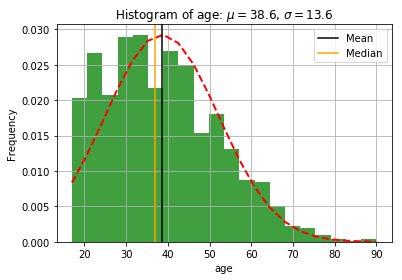

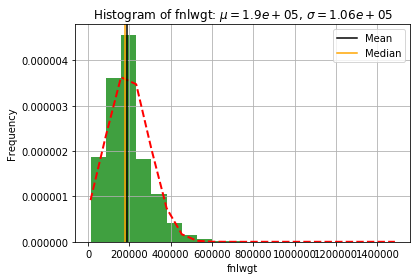

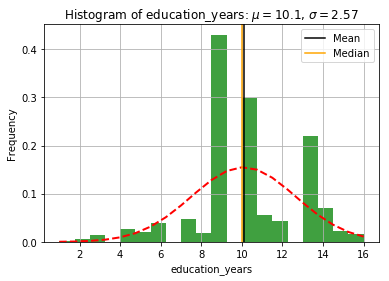

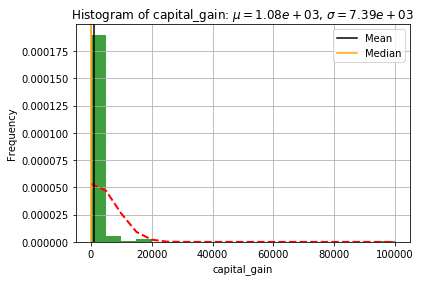

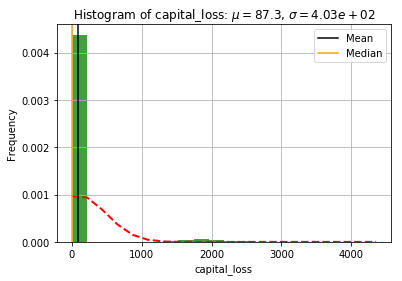

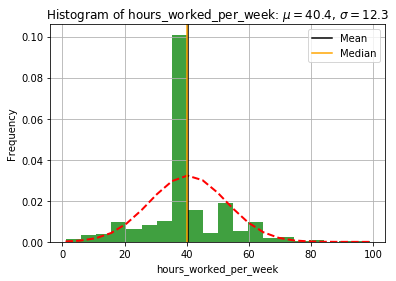

In [21]:
# Plotting the distribution for all of our continous features 
for feat in cont_feat:
    plt.subplot(1,1,1)
    plot_hist(data[feat], feat)
    plt.show()

- We definetly have some skewed distributions. Looking at the captial loss and capital gain columns' measure of spread it is clear are going to need to normalise these columns.
- Also, fnlwgt seems to be skewed. However, I believe this column does not pertain any actual information on our population we're trying to model. For this reason its safe to say we can drop the column. 

In [22]:
# Observing continous data correlations
data.corr()

,age,fnlwgt,education_years,capital_gain,capital_loss,hours_worked_per_week
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768
education_years,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123
capital_gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409
capital_loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256
hours_worked_per_week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000


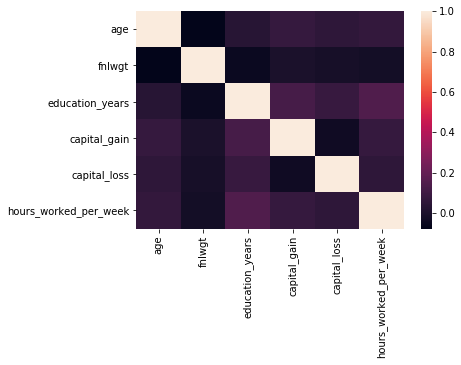

In [23]:
# Visualising the relationships using a pearsons correlation co-efficient method
sb.heatmap(data.corr());

The above may look worrying simply because it would be assumed we would want to find some sort of correlation within our data set. HOWEVER, it is important to note that what we actually want to observe correlations between our input features and **income** variable. 

The fact that none of our continuous features seem to display any collinearity is a **good thing**. It means we wont be inflating our models variance! 

Simply put, we're happy that none of our features relate to each other because we only want them to be related to our income column!

In [24]:
# Calculating the number of individuals making more than and less than $50,000
more_than_50 = data.income.value_counts()[1]
less_than_50 = data.income.value_counts()[0]

In [25]:
# Printing the numbers 
print("The number of individuals making more than $50,000 is {} and less than $50,000 is {}.".format(more_than_50, less_than_50))
print("\nThe percentage of individuals making more than $50,000 is {:.2f}%.".format(100*more_than_50/(data.shape[0])))

The number of individuals making more than $50,000 is 7841 and less than $50,000 is 24720.

The percentage of individuals making more than $50,000 is 24.08%.


Below is a summary table of the number of people making more or less than 50,000:
<table>
<tr><th></th><th colspan = '4'>Number of people</th></tr>
<tr><th rowspan = '1' colspan = '2'>Less than 50,000</th><td colspan ='2'>$24,720$</td></tr>
<tr><th rowspan = '1' colspan = '2'>More than 50,000</th><td colspan ='2'>$7841$</td></tr>


### Conclusion:

#### Validity
It seems we have a few minor preprocessing tasks to complete with this data however, more importantly, this exploration process has made a few things very clear about our data and the validity of a model rooted in it.

We have a **time related validity** issue. This data was tabulated well over 20 years ago and naturally, it can be assumed there has been an evolution in terms of feature relavence for predicting income. Essentially, this comprimises our external validity.

Secondly, our data set is heavily biased towards white, male, americans. It would not be best to try and assume our evaluation metrics would hold for a more diverse set of individuals. The model will likely have a reasonable high degree of bias due to the fact we are lacking in records of other genders, ethnicities and nationality. Again, another external validity issue. 



<a id ="Clean"></a>
### Data Cleaning/Preprocessing

So I have a few tasks set to complete in this stage of our analysis. 

1. **Remove** the fnlwgt column
- **Remove columns with ?'s**
- **Log-transform** skewed distributions 
- **Normalizing** our numerical data
- **Splitting data into target and feature variables**
- **One hot encode** non-numeric data

We'll try and pipeline the cleaning process at the end of this section so we can directly apply it to our test data set for metric evaluation. 
Once these tasks are complete we can begin to fit models to our data and test based on particular evaluation metrics.

#### Removing fnlwgt

In [426]:
# Removing the fnlwgt column in one line
data.drop(['fnlwgt'], axis = 1, inplace = True)

In [27]:
# A few checks it worked
assert data.shape[1] == 14
assert 'fnlwgt' not in data.columns
print('Seems the column was successfully removed, lets do a quick visual')
# Visual Check
data.head()

Seems the column was successfully removed, lets do a quick visual


,age,workclass,education,education_years,marital_status,occupation,realtionship,race,sex,capital_gain,capital_loss,hours_worked_per_week,native_country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [28]:
# Checking the boolean array
(data.isin([' ?']).sum(axis=1)>0)[0:30]

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14     True
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27     True
28    False
29    False
dtype: bool

In [427]:
# indexing the ' ?' rows
q_indx = np.nonzero(data.isin([' ?']).sum(axis=1)>0)[0]

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


In [428]:
# Checking we have the right length in our index array
assert q_indx.shape[0] == num_rows
print("We have correctly got {} number of rows".format(num_rows))

We have correctly got 2399 number of rows


In [429]:
# Checking we are dropping the right rows
assert data.drop(axis=0, index = q_indx).shape[0] == data.shape[0] - num_rows
print("dropping the right number of rows")

dropping the right number of rows


In [430]:
# Storing the drop
data.drop(axis=0, index = q_indx, inplace =True)

#### Transforming skewed continuous data

A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: 'capital_gain' and  'capital_loss'.

For highly-skewed feature distributions, it is common practice to apply a logarithmic transformation on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a *logarithmic transformation* significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of 0 is undefined, so we must translate the values by a small amount above 0 to apply the the logarithm successfully.


In [431]:
# creating a list of of column names
skewed_cols = ['capital_gain','capital_loss']

In [432]:
# Log transforming the skewed features
features_log_transformed = pd.DataFrame(data = data)
features_log_transformed[skewed_cols] = data[skewed_cols].apply(lambda x: np.log(x + 1))

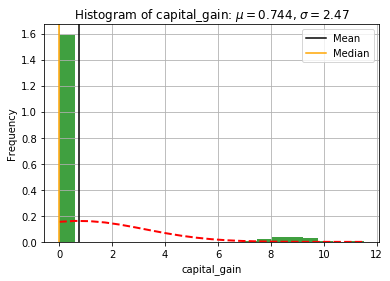

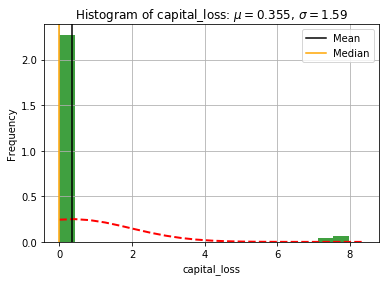

In [35]:
# Visualising our log transformed columns 
for col in skewed_cols:    
    plt.subplot(1,1,1)
    plot_hist(features_log_transformed[col], col)
    plt.show()

To appreciate what was done it might be best to focus on the standard deviation reduction as opposed to the visual (it really doesnt do it justice but this is a difficult concept to visualise). 

#### Normalizing the numerical data

This is a very common process in machine learning algorithm development. 

Applying a scaling to the data does not change the shape of each feature's distribution however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning.

In [ ]:
cont_feat.remove('fnlwgt')

In [434]:
# Initialize a scaler, then apply it to the features with a default of 0 -> 1
scaler = MinMaxScaler()

# Copying the dataframe over to a new one
features_log_minmax_transform = features_log_transformed.copy()
# Transforming our new dataframes continuous features
fitted_scaler = scaler.fit(features_log_transformed[cont_feat])
features_log_minmax_transform[cont_feat] = fitted_scaler.transform(features_log_transformed[cont_feat])

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


**NOTE**: We can ignore the warning. Python is just kindly informing us that one of our columns were converted from an integer data type to a floating point data type. Totally A-okay.  

In [274]:
# Visualising the change with feature scaling
features_log_minmax_transform.head()

,age,workclass,education,education_years,marital_status,occupation,realtionship,race,sex,capital_gain,capital_loss,hours_worked_per_week,native_country,income
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States,<=50K
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States,<=50K
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States,<=50K
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States,<=50K
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba,<=50K


#### Splitting target and features
We want to split our data into our predictors target variables. In our case we simply have 1 target variable and the rest of our columns are the features we want to input into our model. 

In [435]:
# Split the data into features and target label
income_raw = features_log_minmax_transform['income']
features_log_minmax_transform.drop('income', axis = 1, inplace = True)

In [40]:
# Verifying our split worked
assert 'income' not in features_log_minmax_transform.columns
print('Seems our income was correctly dropped from our features dataset')
print('Lets see what our income array looks like:')
income_raw.head()

Seems our income was correctly dropped from our features dataset
Lets see what our income array looks like:


0     <=50K
1     <=50K
2     <=50K
3     <=50K
4     <=50K
Name: income, dtype: object

#### One hot encoding 

From the table in Exploring the Data above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called categorical variables) be converted. One popular way to convert categorical variables is by using the one-hot encoding scheme. One-hot encoding creates a "dummy" variable for each possible category of each non-numeric feature. For example, assume someFeature has three possible entries: A, B, or C. We then encode this feature into someFeature_A, someFeature_B and someFeature_C.

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, 'income' to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as 0 and 1, respectively. In code cell below, I will implement the following:

In [436]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

In [437]:
# Removing whitespace from column headers
features_final.columns = features_final.columns.str.replace(' ', '')

In [438]:
# Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 1 if x == ' >50K' else 0)

In [439]:
# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.\n".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print (encoded[:5])

103 total features after one-hot encoding.

['age', 'education_years', 'capital_gain', 'capital_loss', 'hours_worked_per_week']


In [229]:
# A visualisation of our new data frames
display(features_final.head())
display(income.head(10))


,age,education_years,capital_gain,capital_loss,hours_worked_per_week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,0.301370,0.800000,0.667492,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    1
9    1
Name: income, dtype: int64

### Pipelining the Cleaning Process
Below I will create a basic function just so that we can implement the cleaning process in a more programatic fashion. 



In [440]:
def clean_data(data):
    '''
    INPUT:
    data - Pandas Dataframe of our raw data
    
    OUTPUT:
    features_final - Pandas dataframe of our processed features
    income - Array of our target features (1's,0's)
    
    
    
    Description:
    Cleans the data in a pipeline process
    '''
    # Removing the fnlwgt column in one line
    data.drop(['fnlwgt'], axis = 1, inplace = True)
    
    # indexing the ' ?' rows
    q_indx = list(np.nonzero(data.isin([' ?']).sum(axis=1)>0)[0])
    # Storing the drop
    data.drop(axis=0, index = q_indx, inplace =True)
    
    # list of all continuous features
    cont_feat = list(data.dtypes[data.dtypes == 'int64'].index)
    
    # creating a list of of column names
    skewed_cols = ['capital_gain','capital_loss']
    
    # Log transforming the skewed features
    features_log_transformed = pd.DataFrame(data = data)
    features_log_transformed[skewed_cols] = data[skewed_cols].apply(lambda x: np.log(x + 1))
    
    
    # Initialize a scaler, then apply it to the features with a default of 0 -> 1
    scaler = MinMaxScaler()

    # Copying the dataframe over to a new one
    features_log_minmax_transform = features_log_transformed.copy()
    # Transforming our new dataframes continuous features
    fitted_scaler = scaler.fit(features_log_transformed[cont_feat])
    features_log_minmax_transform[cont_feat] = fitted_scaler.transform(features_log_transformed[cont_feat])
    
    
    # Split the data into features and target label
    income_raw = features_log_minmax_transform['income']
    features_log_minmax_transform.drop('income', axis = 1, inplace = True)
    
    
    
    # One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
    features_final = pd.get_dummies(features_log_minmax_transform)
    features_final.columns = features_final.columns.str.replace(' ', '')
    
    # Encode the 'income_raw' data to numerical values
    income = income_raw.apply(lambda x: 1 if x == ' >50K' else 0)
    
    return features_final, income

In [441]:
# Running our cleaning function on our test data set
test_features, test_income = clean_data(data_test)

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [442]:
# Checking the shape of our data
test_features.shape

(15060, 102)

### **Uh Oh!** 
it seems we are missing a columns in our cleaned test set. Lets investigate.

In [443]:
# Checking the missing column
for i in list(features_final.columns):
    if i not in list(test_features.columns):
        print(i)

native_country_Holand-Netherlands


### The fix

The issue here is that our test data set doesn't seem to have anyone from the Netherlands. Its a unique case and we have two options. 

1. We could merge our data sets from the loading stage and then run the cleaning function on both of them. Then using sklearn's train_test_split function we could separate our data into test and train sets. 
2. We could add a new column called 'native_country_ Holand-Netherlands' and assign 0's to the whole column for our test_features.

**Approach 1 is a much more failsafe** way of processing our data since we can ensure consistency in our pre-processing step. This means if we had data flowing in a production environment we would not run into as many bugs... Or at least not in the preprocessing stage!

So I will reload the data below and pass it through our wonderful clean_data function!



In [444]:
# List of column names to pass to the read_csv function
col_names = ['age','workclass','fnlwgt','education','education_years','marital_status','occupation','relationship','race',
         'sex','capital_gain','capital_loss','hours_worked_per_week','native_country','income']
# Loading in our training data
data = pd.read_csv('adultdata', names=col_names)
# Loading in the testing data 
data_test = pd.read_csv('adulttest', names=col_names, skiprows=1)


In [445]:
# Quick check that everything was loaded in correctly
assert (data_test.columns == data.columns).all()
print('Data loaded correctly!')

Data loaded correctly!


In [446]:
# Merging our dataframes
merged_data = pd.concat([data,data_test],ignore_index = True)

In [269]:
# Checking our data was correctly loaded in 
assert merged_data.shape[0] == data.shape[0] + data_test.shape[0]
assert merged_data.shape[1] == data.shape[1] == data_test.shape[1]
assert merged_data.isna().sum().sum() == 0
print("All is well")

All is well


In [447]:
# Cleaning our merged data
features, target = clean_data(merged_data)

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [448]:
# Checking the features data
features.head()

,age,education_years,capital_gain,capital_loss,hours_worked_per_week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,0.301370,0.800000,0.667492,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
features.shape

(45222, 103)

In [56]:
# Checking our target data
target.head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    1
9    1
Name: income, dtype: int64

### Splitting into Test/Train sets


In [449]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size = 0.1, 
                                                    random_state = 0)

In [450]:
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 40699 samples.
Testing set has 4523 samples.


<a id ="Test"></a>
### Model Testing and Evaluation

Now for the super fun part! In this section, we will investigate three different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners.

Below I'll give a little background of each supervised learner in terms of high level limitations and industry uses.

**Model Selection**:

The first model is **AdaBoost**. Adaboost is prominant in the industry of computer vision and speech recognition. This model is a powerful classification algorithm that is not prone to overfitting (due to the fact it utilises so many weak learners) and is fairly simple to implement. However, considering the disadvantages of this model are the fact that it is vulnerable to noisy data and outliers. This model could be succesful when considering that we have a clean dataset on which to preform all the required iterations of weak learners.

The second model is **Support Vector Machines** which is used widely in industry from facial recognition to hand writing recognition. A key advantage of SVMs is the ability to utilise the kernel trick which can help to solve almost any complex problem (with the appropriate kernel). However, this being said, it can be rather difficult to pick the right kernel function. Additionally, it can have long training times for larger data sets and SVMs can be prone to overfitting. This model may be appropriate as our data seems that it may have clearly defined boundaries which are integral to the SVM algorithm.

Finally, we could use the **Random Forest algorithm**. This is a commonly used algorithm in the banking sector to try and identify customers who are more likely to repay debt etc. It is also used to identify fraud with regards to spending (also a part of the banking sector). One key strength of this model is the fact that it rarely overfits. However, this is dependant on the number of "trees" in the forest. Also, the model ignores irrelavent features fairly well too. One glaring limitation of this model is when working with large data, our prediction time can be slow depending on how complex our "forest" is. Also, it has a black box effect in which inteprating our model can be rather difficuly. This model may be a good candidate as we seem to have many features of which not all will be crucial and this model should be able to create an accurate classifier.

To properly evaluate the performance of each model I've chosen, it's important that I create a training and predicting pipeline that allows a quick and effective model training process using various sizes of training data and perform predictions on the testing data. The implementation here will be used in the following section. In the code block below, I will implement the following:

- Fit the learner to the sampled training data and record the training time.
- Perform predictions on the test data X_test, and also on the first 300 training points X_train[:300].
    - Record the total prediction time.
- Calculate the accuracy score for both the training subset and testing set.
- Calculate the F-score for both the training subset and testing set.
    - set the beta parameter!

In [451]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        

        
    # Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
    
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
            
    # Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=0.5)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

Before we being with training our supervised ML models, we may want to know how a naive predictor would perform on this data set. That being, if we assumed all data points to be correctly classified as an earner above 50,000 , how many points would we miss classify? This gives us a bench mark for our models performance. 

In [60]:
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
                    # encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case


# Calculating accuracy, precision and recall
accuracy = (TP)/(TP+FP)
recall = (TP/(TP+FN))
precision = (TP/(TP+FP))
print(recall)

# Calculating F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta=0.5
fscore = (1+beta**2)*((precision*recall)/(((beta**2)*precision)+recall))

print (FP)
# Printing the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy,fscore))

1.0
22654
Naive Predictor: [Accuracy score: 0.2489, F-score: 0.2929]


In the code cell, I will implement the following:

- Import the three supervised learning models I've discussed in the previous section.
- Initialize the three models and store them in 'clf_A', 'clf_B', and 'clf_C'. clf stands for classifier.
    - Use a 'random_state' for each model you use, if provided.
    - Note: I will use the default settings for each model — we will then tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
    - Store those values in 'samples_1', 'samples_10', and 'samples_100' respectively.

AdaBoostClassifier trained on 406 samples.
AdaBoostClassifier trained on 4069 samples.
AdaBoostClassifier trained on 40699 samples.
LinearSVC trained on 406 samples.
LinearSVC trained on 4069 samples.
LinearSVC trained on 40699 samples.
RandomForestClassifier trained on 406 samples.
RandomForestClassifier trained on 4069 samples.


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 40699 samples.


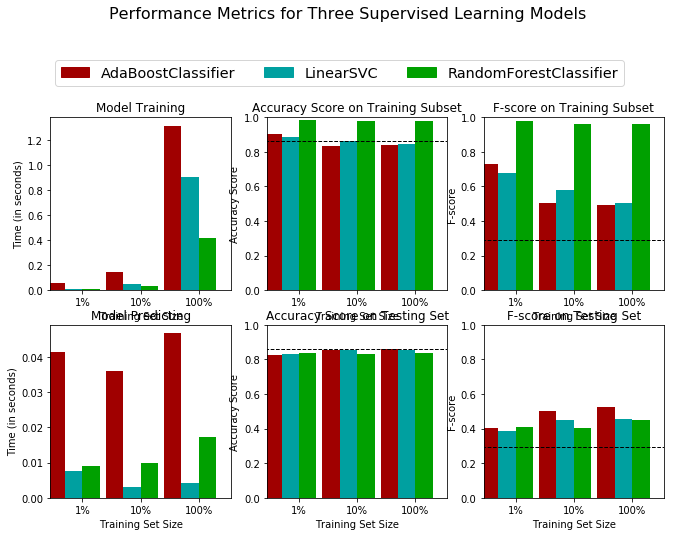

In [453]:
# Initializing the three models
clf_A = AdaBoostClassifier(random_state=0)
clf_B = LinearSVC(random_state=0)
clf_C = RandomForestClassifier(random_state=0)


# Calculating the number of samples for 1%, 10%, and 100% of the training data
# Samples_100 is the entire training set i.e. len(y_train)
# Samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# Samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_1 = int(X_train.shape[0] / 100)
samples_10 = int(X_train.shape[0] / 10)
samples_100 = int(X_train.shape[0])

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
# Using the visualisation package visuals.py
vs.evaluate(results,  accuracy, fscore)

#### Choosing the Best Model 

so, it seems the **Adaboost classifier** is the best model from the three that were tested. This is clear as it has the highest **F score** out of all the models. However, the training and predicting time seems to be the largest but in our case this is probably not a signifigant issue as our model wont need to make real time predictions. If it were, we might be better suited to pick the **SVM** as it offers similar predictive capabilities but requires less than half the time in predicting and signifigantly less time in model training.


#### Describing the Model in Layman's Terms
The adaboost model is considered an Ensemble Method. In essence, what this means is that the model builds on very rudementary and simple models (usually decision trees with a depth of 1) that are called weak learners as they tend to be poor models for the data. These learners are built through an iterative process that weights the incorrectly classified data points higher so that the next model iteration accounts for these points more and essentially classifies them more correctly. Adaboost builds on these iterative models by weighting each models accuracy. From these weights (between -1 and 1) the model determines how correct each weak learner is and then combines them to create a single strong learner. If the iterative model is incorrect most of the time, it will score nearer to -1 and vice versa. A iterative model that is correct about 50% of the time is weighted closer to 0 since it doesnt provide the overall model with much information on the training data. Essentially, **our Strong Learner is comprised of many Weak Learners**.

#### Model Tuning

Lets fine tune the chosen model. Using grid search (GridSearchCV) with at least one important parameter tuned with at least 3 different values. I will need to use the entire training set for this. In the code cell below, I will need to implement the following:

- Import sklearn.grid_search.GridSearchCV and sklearn.metrics.make_scorer.
- Initialize the classifier I've chosen and store it in clf.
    - Set a random_state if one is available to the same state I set before.
- Create a dictionary of parameters I wish to tune for the chosen model.
    - Example: parameters = {'parameter' : [list of values]}.
- Use make_scorer to create an fbeta_score scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier clf using the 'scorer', and store it in grid_obj.
- Fit the grid search object to the training data (X_train, y_train), and store it in grid_fit.

In [454]:
# Initializing the classifier
clf = AdaBoostClassifier(random_state=0, base_estimator = DecisionTreeClassifier(max_depth=1))

# Creating the parameters list I wish to tune, using a dictionary.
parameters = {'n_estimators':[45,50,100,200,500],'learning_rate':[0.2,0.4,0.8,1]}
# Making an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score,beta=0.5)

# Performing grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=3)

# Fitting the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Geting the estimator
best_clf = grid_fit.best_estimator_

# Making predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)
    
# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8627
F-score on testing data: 0.5227

Optimized Model
------
Final accuracy score on the testing data: 0.8625
Final F-score on the testing data: 0.5278


In [166]:
# Finding the best parameters
grid_fit.best_params_

{'learning_rate': 1, 'n_estimators': 500}

In [167]:
### Creating a confusion matrix object
confusion_matrix = confusion_matrix(y_test, predictions)
confusion_matrix  = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

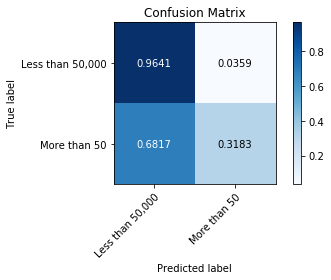

In [168]:
classes = ['Less than 50,000','More than 50']
confusion_matrix  = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(confusion_matrix.shape[1]),
        yticks=np.arange(confusion_matrix.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title="Confusion Matrix",
        ylabel='True label',
        xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

fmt = '.4f'
thresh = confusion_matrix.max() / 2.
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(j, i, format(confusion_matrix[i, j], fmt),
                ha="center", va="center",
                color="white" if confusion_matrix[i, j] > thresh else "black")
fig.tight_layout()
ax;

In [169]:
# Checking our accuracy for the model 
accuracy = (predictions == y_test).mean()
print("Our accuracy for the AdaBoost model was {0:.2f}%".format(100*accuracy))

Our accuracy for the AdaBoost model was 86.27%


In [170]:
# Checking our Precision
print("Our precision for the model was {0:.2f}%".format(100*precision_score(y_test, predictions)))

Our precision for the model was 62.26%


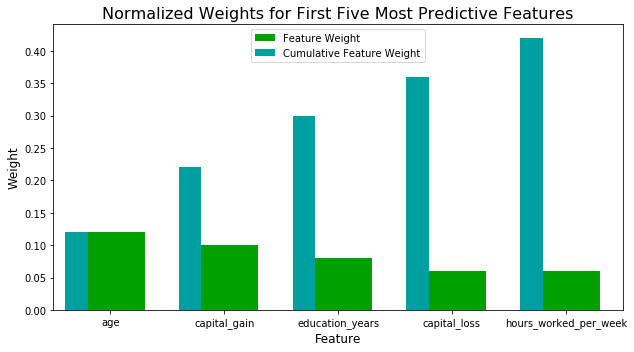

In [172]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier().fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

Many of the features I guessed are apparent in the model. However, it seems capital loss is much higher of value in our predictive model than I initially thought. This makes sense when we consider that those we have a high capital loss may not feel inclined to donate to charity as it would be an added risk for themselves.

In [175]:
model

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [176]:
grid_fit

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [45, 50, 100, 200, 500], 'learning_rate': [0.2, 0.4, 0.8, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=0.5), verbose=0)

In [179]:
best_clf

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=500, random_state=0)

In [174]:
grid_fit.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [45, 50, 100, 200, 500], 'learning_rate': [0.2, 0.4, 0.8, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=0.5), verbose=0)>

In [219]:
# Exporting the highest accuracy model
filename = 'model.pkl'
pickle.dump(best_clf, open(filename, 'wb'))

In [220]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [221]:
# Ensuring the loaded model is fine 
print("{0:.2f}% Accuracy".format(100*(y_test == loaded_model.predict(X_test)).mean()))

86.25% Accuracy


In [461]:
features.to_csv(path_or_buf  = r'/Users/surohittandon/Desktop/WebApp/clean_features.csv',index=False)

In [530]:
data.native_country.value_counts()

 United-States                 29170
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

In [478]:
request = {'age':[5],'workclass':["State-gov"],'education':["Bachelors"],'education_years':[9],'marital_status':["Never-married"],
         'occupation':["Adm-clerical"],'relationship':["Not-in-family"],'race':["White"],'sex':["Male"],'capital_gain':[4000],'capital_loss':[100],
         'hours_worked_per_week':[40],'native_country':["United-States"]}



In [479]:
data_dict = {'age':[0],'workclass':[0],'education':[0],'education_years':[0],'marital_status':[0],
         'occupation':[0],'relationship':[0],'race':[0],'sex':[0],'capital_gain':[0],'capital_loss':[0],
         'hours_worked_per_week':[0],'native_country':[0]}

In [487]:
for i in data_dict:
    data_dict[i] = [request[i][0]]

In [488]:
data_dict

{'age': [5],
 'workclass': ['State-gov'],
 'education': ['Bachelors'],
 'education_years': [9],
 'marital_status': ['Never-married'],
 'occupation': ['Adm-clerical'],
 'relationship': ['Not-in-family'],
 'race': ['White'],
 'sex': ['Male'],
 'capital_gain': [4000],
 'capital_loss': [100],
 'hours_worked_per_week': [40],
 'native_country': ['United-States']}

In [490]:
features_log_minmax_transform

,age,workclass,education,education_years,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_worked_per_week,native_country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.000000,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.000000,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.000000,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.000000,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.000000,0.397959,Cuba
5,0.273973,Private,Masters,0.866667,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.000000,0.000000,0.397959,United-States
6,0.438356,Private,9th,0.266667,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.000000,0.000000,0.153061,Jamaica
7,0.479452,Self-emp-not-inc,HS-grad,0.533333,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.000000,0.448980,United-States
8,0.191781,Private,Masters,0.866667,Never-married,Prof-specialty,Not-in-family,White,Female,0.829751,0.000000,0.500000,United-States
9,0.342466,Private,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.742849,0.000000,0.397959,United-States


In [491]:
data_dict = {'age':[0],'workclass':[0],'education':[0],'education_years':[0],'marital_status':[0],
             'occupation':[0],'relationship':[0],'race':[0],'sex':[0],'capital_gain':[0],'capital_loss':[0],
             'hours_worked_per_week':[0],'native_country':[0]}

In [519]:
requests = {'workclass': 'Federal-gov', 'education': '10th', 'occupation': 'Adm-clerical', 'education_years': '15', 'hours_worked_per_week': '40', 'age': '22', 'relationship': 'Husband', 'race': 'Amer-Indian-Eskimo', 'marital_status': 'Never-married', 'sex': '1', 'native_country': '1', 'capital_gain': '95000', 'capital_loss': '3200'}

In [520]:
for i in requests:
    print(requests[i])

Federal-gov
10th
Adm-clerical
15
40
22
Husband
Amer-Indian-Eskimo
Never-married
1
1
95000
3200


In [521]:
requests['age']

'22'

In [522]:
cont_feat = ['age',
     'education_years',
     'capital_gain',
     'capital_loss',
     'hours_worked_per_week']

for i in data_dict:
    if i in cont_feat:
        out = requests[i]
        out = int(out)
        data_dict[i] = [out]
    else:
        data_dict[i] = [requests[i]]

In [523]:
data_dict

{'age': [22],
 'workclass': ['Federal-gov'],
 'education': ['10th'],
 'education_years': [15],
 'marital_status': ['Never-married'],
 'occupation': ['Adm-clerical'],
 'relationship': ['Husband'],
 'race': ['Amer-Indian-Eskimo'],
 'sex': ['1'],
 'capital_gain': [95000],
 'capital_loss': [3200],
 'hours_worked_per_week': [40],
 'native_country': ['1']}

In [529]:
pd.DataFrame.from_dict(data_dict).iloc[:,0:-2]

,age,workclass,education,education_years,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss
0,22,Federal-gov,10th,15,Never-married,Adm-clerical,Husband,Amer-Indian-Eskimo,1,95000,3200
